# Evaluation of ResNet-18 using CIFAR-100
In this notebook we will go through key evaluation metrics for CNN in order to analyse how efficiently and accurately ResNet-18 model predicts on data CIFAR-100.

## Setup

In [13]:
import os, time, torch
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

from model import TransferModel
from data_preparation.CIFAR_100.data_cifar_100 import test_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cpu


Define specific variables for this evaluation script.

In [14]:
model_name = 'ResNet-18'
dataset_name = 'CIFAR-100'
class_labels = test_loader.dataset.classes
class_labels[:8]

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle']

Import data for evaluation taken from training step.

In [15]:
full_history = pd.read_csv('data_evaluation_resnet18/CIFAR_100/resnet18_cifar100_full_best_training_history.csv')
full_history.columns

Index(['train_loss', 'val_loss', 'val_acc'], dtype='object')

In [16]:
head_history = pd.read_csv('data_evaluation_resnet18/CIFAR_100/resnet18_cifar100_head_best_training_history.csv')
head_history.columns

Index(['train_loss', 'val_loss', 'val_acc'], dtype='object')

In [17]:
lastblock_history = pd.read_csv('data_evaluation_resnet18/CIFAR_100/resnet18_cifar100_lastblock_best_training_history.csv')
lastblock_history.columns

Index(['train_loss', 'val_loss', 'val_acc'], dtype='object')

In [18]:
test_loss = pd.read_csv('data_evaluation_resnet18/CIFAR_100/resnet18_test_loss_list.csv')
test_loss.columns

Index(['batch_loss'], dtype='object')

In [19]:
test_pred = pd.read_csv('data_evaluation_resnet18/CIFAR_100/resnet18_test_predictions.csv')
y_true = test_pred.True_Label
y_pred = test_pred.Predicted_Label
test_pred.columns

Index(['True_Label', 'Predicted_Label'], dtype='object')

In [20]:
model_path = 'data_evaluation_resnet18/CIFAR_100/resnet18_cifar100_full_best.pth'

## Visualisate Model Predictions

Create instance of our model.

In [21]:
model = TransferModel(num_classes=100, backbone='resnet18', pretrained=False).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

Function to visualisate model predictions (with True and Predicted labels).

In [22]:
def visualize_model_predictions(model, loader, class_labels, target_class=None, num_images=5, device="cpu"):
    samples = [] 
    
    if target_class is not None: 
        target_class_id = class_labels.index(target_class) 
    
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        for images, labels in loader: 
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            # Define filter
            if target_class:
                mask = (labels == target_class_id) & (preds != target_class_id)
            else:
                mask = torch.ones_like(labels, dtype=torch.bool)
            
            # Store matching images
            if mask.any():
                for img, t, p in zip(images[mask], labels[mask], preds[mask]):
                    samples.append((img.cpu(), t.item(), p.item()))
                    if len(samples) >= num_images: break
            
            if len(samples) >= num_images: break
        
    if not samples: return print("No images found.")

    plt.figure(figsize=(15, 4))
    plt.suptitle(f'{model_name} using {dataset_name}', fontsize=16, weight='bold', y=1.02)
    for i in range(len(samples)):
        ax = plt.subplot(1, num_images, i + 1)
        
        img_tensor, true_id, pred_id = samples[i]
        img = img_tensor.permute((1, 2, 0)).numpy() 
        
        # Denormalization step
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean # (img - mean) / std
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        
        true_label = class_labels[true_id]
        pred_label = class_labels[pred_id]
        
        # Green for correct, Red for wrong
        color = 'green' if true_id == pred_id else 'red'
        
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
        plt.axis("off")
    plt.show()

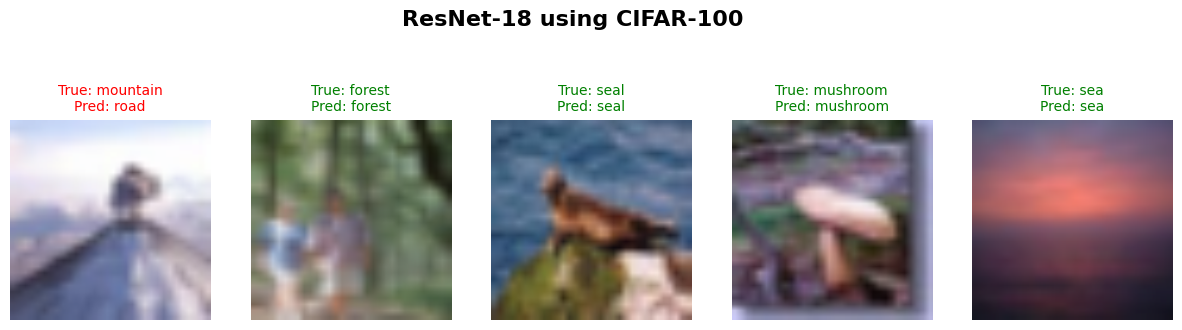

In [23]:
visualize_model_predictions(model, test_loader, class_labels, num_images=5, device=device)

## Training Dynamics
### Stability & Overfitting Check
In this section we will compare how well model was trained during 3 different transfer learning strategies:
* **Full fine-tuning (full)** -> Training all layers of the network.
* **Linear probing (head)** -> Training only the final classification head while keeping the backbone frozen.
* **Partial fine-tuning (last)** -> Unfreezing the final blocks of the MobileNet architecture to allow for feature adaptation.

In [24]:
# define dictionary to store for each strategy -> name(key), df, color
strategies = {
    "Head Only": {"df": head_history, "color": "#e57373"},
    "Last Block": {"df": lastblock_history, "color": "#ffb74d"},
    "Full Tuning": {"df": full_history, "color": "#81c784"}
}

### Max Accuracy (Top-1 Accuracy)

This metric shows what percentage of the time model's highest-probability prediction matches with actual label.
$$\text{Accuracy} = \frac{1}{N} \sum_{i=1}^{N} \mathbb{1}(\hat{y}_i = y_i)$$

Max accuracy

Head Only: 57.36%
Last Block: 75.34%
Full Tuning: 80.78%


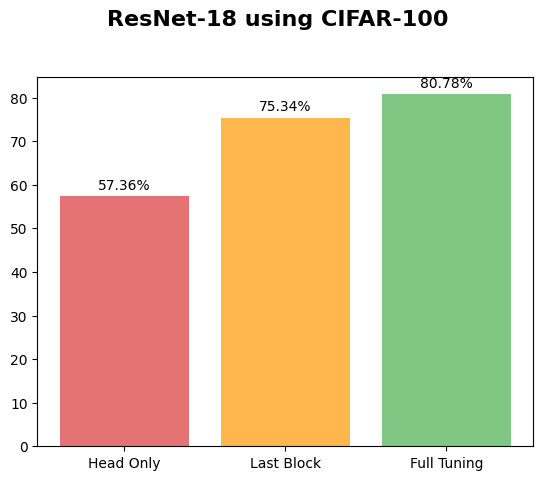

In [25]:
print("Max accuracy\n")

for key, item in strategies.items():
    item['maxAcc'] = item['df']['val_acc'].max() * 100
    print(f"{key}: {item['maxAcc']:.2f}%")

bars = plt.bar(strategies.keys(), [strategies[i]['maxAcc'] for i in strategies], color=[strategies[i]['color'] for i in strategies])
plt.bar_label(bars, padding=3, fmt='%.2f%%')
plt.suptitle(f'{model_name} using {dataset_name}', fontsize=16, weight='bold', y=1.02)
pass

**Head Only results** show that this approach does not work well. It stops the feature extractor from changing and only trains the last classifier. The score for the Head Only results is the lowest at 57.36 percent. This tells us that the features from -trained models are not good enough, for the complex CIFAR-100 dataset. The CIFAR-100 dataset is really hard. The Head Only results are not good.

<br>**Last Block results:** If we only unfreeze the layers of ResNet-18 the ResNet-18 model gets a lot better at accuracy all the way up to 75.34%. This means the ResNet-18 model is good at learning things that're not very specific but the ResNet-18 model still has trouble, with some of the smaller details that it needs to know to tell apart 100 different classes of things.

<br>**Full Tuning results:** Unfreezing the entire network results in the highest accuracy of 80.78%. This strategy allows the model to adjust features at every level—from simple edges to complex shapes—maximizing its ability to categorize the diverse CIFAR-100 images.

### Combined Validation Accuracy
With this metric we can compare learning capabilities of three strategies of training model.

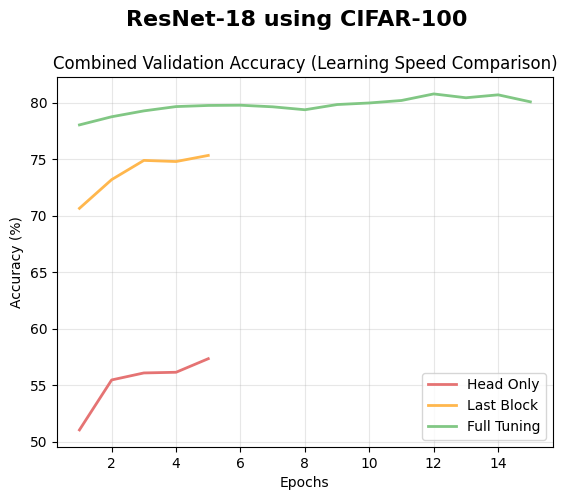

In [26]:
for key, item in strategies.items():
    df = item['df']
    epochs = range(1, len(df) + 1)
    plt.plot(epochs, df['val_acc'] * 100, label=key, color=item['color'], linewidth=2)

plt.suptitle(f'{model_name} using {dataset_name}', fontsize=16, weight='bold', y=1.02)
plt.title('Combined Validation Accuracy (Learning Speed Comparison)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Full Model Strategy** is really good. It gets the results because it starts with a high accuracy of around 78 percent. This strategy is better than the methods and it keeps getting better going over 80 percent at its best. This shows that Deep Fine-Tuning is very important, for understanding the complexity of the Full Model Strategy and CIFAR-100. The Full Model Strategy and CIFAR-100 work well together when we use Deep Fine-Tuning.

<br>**Head Only Strategy** does not work well. We look at the accuracy curve. It starts really low at around 51 percent. The Head Only Strategy struggles to do than 57 percent. This means the Head Only Strategy is underfitting. The pre-trained features that the Head Only Strategy uses are just too basic. They are not good enough to tell the difference, between the 100 classes that the Head Only Strategy is trying to figure out.

<br>**Last Block Strategy:** This strategy shows an intermediate result, starting at ~71% and reaching ~75%. This indicates that unfreezing the last convolutional block helps the model learn some high-level features specific to CIFAR-100, but it still misses the deeper nuances captured by the full model.

### Training Loss vs Validation Loss

These graphs will show us how well model generalizes to unseen data depending on which training strategy was used.

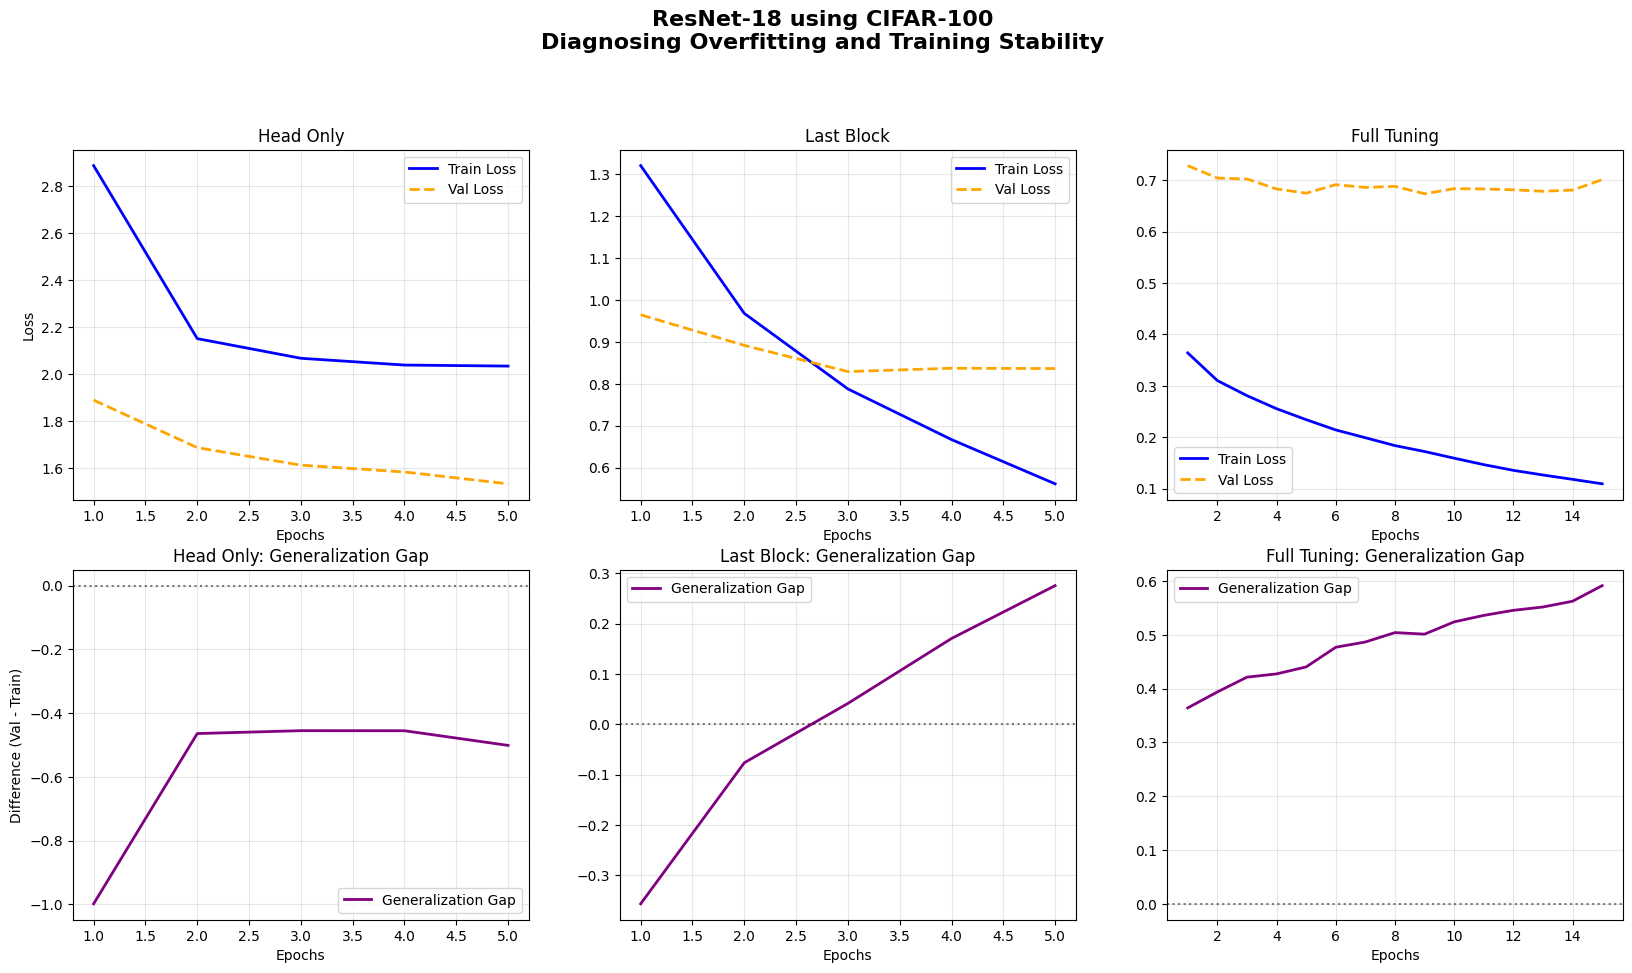

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for ax, (key, item) in zip(axes[0], strategies.items()):
    df = item['df']
    epochs = range(1, len(df) + 1)
    
    #Training Loss
    ax.plot(epochs, df['train_loss'], label='Train Loss', color='blue', linewidth=2)
    
    #Validation Loss
    ax.plot(epochs, df['val_loss'], label='Val Loss', color='orange', linestyle='--', linewidth=2)
    
    ax.set_title(f'{key}', )
    ax.set_xlabel('Epochs')

    if key == "Head Only":  ax.set_ylabel('Loss')

    ax.legend()
    ax.grid(True, alpha=0.3)

#plotting Generalisation Gap Metric
for ax, (key, item) in zip(axes[1], strategies.items()):
    df = item['df']
    epochs = range(1, len(df) + 1)

    # Calculate gap
    df['gap'] = df['val_loss'] - df['train_loss']
    
    ax.plot(epochs, df['gap'], label='Generalization Gap', color='purple', linewidth=2)
    ax.axhline(y=0, color='black', linestyle=':', alpha=0.5)
    
    ax.set_title(f'{key}: Generalization Gap')
    ax.set_xlabel('Epochs')

    if key == "Head Only": ax.set_ylabel('Difference (Val - Train)')
    
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle(f'{model_name} using {dataset_name}\nDiagnosing Overfitting and Training Stability', fontsize=16, weight='bold', y=1.02)
plt.show()

**Head Only:**

* loss curve -> Validation loss is consistently lower than training loss, indicating training images are harder to learn than clean validation data.

* generalisation gap -> Remains negative throughout the training process.

> Underfitting -> High bias -> The frozen feature extractor prevents the model from learning "hard" training examples effectively .


<br>**Last Block:**

* loss curve -> Training loss drops sharply, crossing below the validation loss curve between epoch 2 and 3.

* generalisation gap -> Rises from negative to cross zero at ~epoch 2.5.

> Balanced Transition -> The model's capacity matches data complexity at ~epoch 2.5; beyond this point, the widening gap signals the start of overfitting.


<br>**Full Model:**

* loss curve -> Validation loss (~0.7) remains significantly higher than training loss (~0.1) throughout the entire process.

* generalisation gap -> Starts positive and rises continuously, reaching ~0.6.

> Significant Overfitting -> High variance -> The large gap confirms the model has memorized training data, but this is accepted to achieve the highest accuracy (~80%).

## High-Level Performance 
### Global Metrics Comparison
Aim is to analyse the model accuracy, precision and f1-score from the best training strategy (by generating theirs distributions).

Function to plot distribution of metrics.

In [28]:
def print_distribution(df_report, metric:str):
    scores = (df_report[metric] * 100).copy()

    #we drop the global metrics so we only analyze the specific classes (apple, bear, etc.)
    summary_rows = ['accuracy', 'macro avg', 'weighted avg']
    class_scores = scores.drop(summary_rows, errors='ignore')

    # Kernel Density Estimate (KDE) line
    sns.histplot(class_scores, kde=True, bins=15, edgecolor='white', color='#4c72b0')

    # mean performance
    mean_val = class_scores.mean()
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean {metric}: {mean_val:.1f}%')

    plt.suptitle(f'{model_name} using {dataset_name}', fontsize=16, weight='bold', y=1.02)
    plt.title(f'Distribution of {metric} Per Class', fontsize=14, weight='bold')
    plt.xlabel(f'{metric} (%)', fontsize=12)
    plt.ylabel('Number of Classes', fontsize=12)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

Global characteristics

In [29]:
# generate report for all 100 classes
report_dict = classification_report(
    y_true, 
    y_pred, 
    target_names=class_labels, 
    output_dict=True
)

df_report = pd.DataFrame(report_dict).transpose()
df_report.head(5)

,precision,recall,f1-score,support
apple,0.950000,0.95,0.950000,100.0
aquarium_fish,0.892157,0.91,0.900990,100.0
baby,0.657407,0.71,0.682692,100.0
bear,0.669725,0.73,0.698565,100.0
beaver,0.657143,0.69,0.673171,100.0


To get main performance metrics 'classification_report' was used.

In [30]:
report = classification_report(y_true, y_pred, output_dict=True)

print(f"Global Accuracy:    {report['accuracy'] * 100:.2f}%")
print(f"Macro Precision:    {report['macro avg']['precision'] * 100:.2f}%")
print(f"Weighted Precision: {report['weighted avg']['precision'] * 100:.2f}%")
print(f"Macro F1-Score:     {report['macro avg']['f1-score'] * 100:.2f}%")

Global Accuracy:    80.22%
Macro Precision:    80.48%
Weighted Precision: 80.48%
Macro F1-Score:     80.22%


### Precision
This metrics shows us quality or purity of models predictions. High precision means that we can be confident that model identifies images correctly, for low - model labels many things even when they are incorrect, leading to many false alarms.

$$Precision = \frac{TP}{TP + FP}$$
> Out of all the items the model **claimed** to catch, how many were **actually** positive?

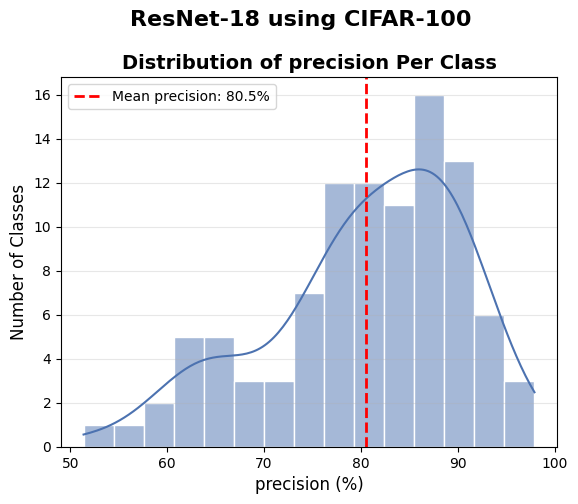

In [31]:
print_distribution(df_report,'precision')

The precision scores are all over the place, averaging around 80.5%. This tells us the model is really inconsistent — it does a great job on some easy classes (nearly 100%), but gets confused on the harder ones, dropping down to around 50% accuracy.

### Recall
This metric measures the "completeness" of your model's predictions. We can find it by the formula:

$$Recall = \frac{TP}{TP + FN}$$

> Out of all the items that are **actually** positive, how many did the model **manage** to catch?

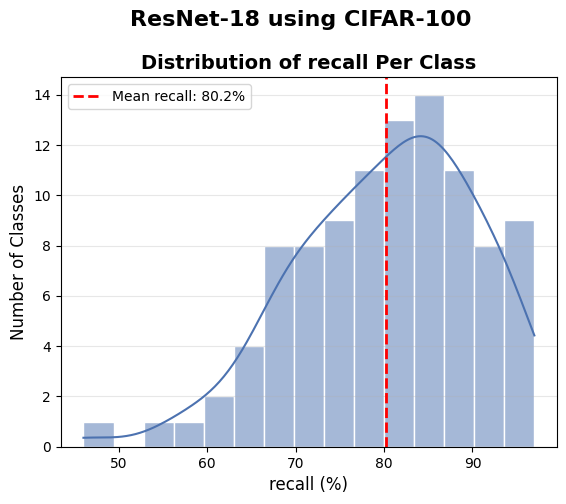

In [32]:
print_distribution(df_report,'recall')

The recall scores are pretty spread out with an average of 80.2%, showing that while the model handles most classes well, it really struggles with a few hard ones where the score drops below 50%.

### F1-Score
$$\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$
> How well does the model **balance** catching all the **right items** (Recall) while **avoiding wrong** ones (Precision)?

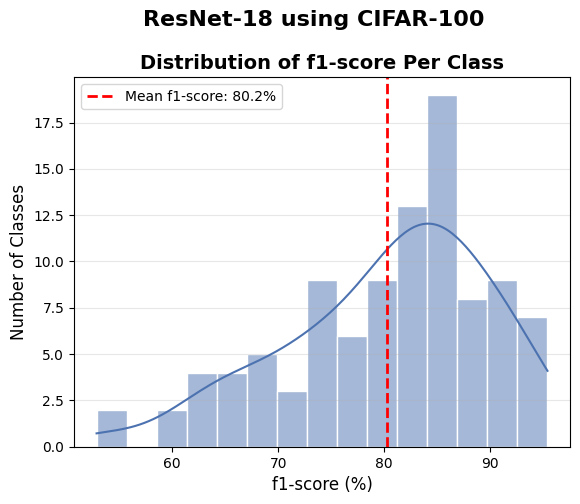

In [33]:
print_distribution(df_report,'f1-score')

The F1-scores average out to 80.2%, showing that while the model nails most classes with scores in the high 80s, there's a stubborn group of tricky classes dragging the performance down to near 55%.

## Class Level Analytics
### Confusion Matrix
Using confusion matrix we can see not only one single score like for accuracy for example, but also we can easily track where and how those mistakes occurred.

<br>In our case for CIFAR-100 we will firstly generate 100 matrices with 2x2 grid. It will show binary implementation of confusion matrices for each class separately. Then we will see confusion matrix in heatmap implementation which will help us to extract top 10 wrongly classified classes.

Binary confusion matrix:
$$\begin{bmatrix}
\text{True Negatives (TN)} & \text{False Positives (FP)} \\
\text{False Negatives (FN)} & \text{True Positives (TP)}
\end{bmatrix}$$

In [34]:
#make y_true and y_pred to have str classes names not numbers
y_true_classes = [class_labels[i] for i in y_true]
y_pred_classes = [class_labels[i] for i in y_pred]

# calculates confusion matrix for each class
overall_confusion_matrix = confusion_matrix(y_true, y_pred)
per_class_confusion_matrices = multilabel_confusion_matrix(y_true_classes, y_pred_classes, labels=class_labels)

n = 3
print(f'Confusion matrices for {n} classes\n')
for i in range(n):
    print(f'{class_labels[i]}')
    print(per_class_confusion_matrices[i],'\n')

Confusion matrices for 3 classes

apple
[[9895    5]
 [   5   95]] 

aquarium_fish
[[9889   11]
 [   9   91]] 

baby
[[9863   37]
 [  29   71]] 



To understand more easily what confusion matrices mean let's analyse one case from above

In [35]:
def print_analytics_of_conf_matrix(cm, target_class):
    target_class_id = class_labels.index(target_class) if type(target_class)==str else target_class
    target_class_name = target_class if type(target_class)==str else target_class

    target_cm = cm[target_class_id]

    print(f'Confusion matrix for {target_class_name}')
    print(target_cm)
    
    indices = [i for i, x in enumerate(y_true) if x == target_class_id] # actual label
    predictions_for_target = [y_pred[i] for i in indices] # predicts

    counts = Counter(predictions_for_target) # count

    print(f"\nWhen image was actually '{target_class_name}', but the model predicted:")
    for pred_id, count in counts.most_common(5):
        print(f" - {class_labels[pred_id]}: {count} times")

In [36]:
print_analytics_of_conf_matrix(per_class_confusion_matrices, 'apple')

Confusion matrix for apple
[[9895    5]
 [   5   95]]

When image was actually 'apple', but the model predicted:
 - apple: 95 times
 - sweet_pepper: 3 times
 - snail: 1 times
 - bowl: 1 times


Plot of confusion matrix where rows represents true class label, columns - predicted class and diagonal represents correct predictions. All not diagonal cells represents mistakes.

In [37]:
def conf_matrix_heatmap(cm, model_name, data_name, dots_to_plot:list[list[int]]=None, class_labels=None):
    sns.heatmap(cm, 
                annot=False, # if true numbers will appear
                cmap='Blues', # color 'Blues' or 'viridis' 
                vmax=20,
                cbar_kws={'label': 'Number of Images'}
                )           
    if dots_to_plot:
        x_coords = []
        y_coords = []

        for true_id, pred_id in dots_to_plot:
            x_coords.append(pred_id + 0.5)  # -> to be in middle of square
            y_coords.append(true_id + 0.5)
            
            print(f"Marking: {class_labels[true_id]} (ID {true_id}) -> {class_labels[pred_id]} (ID {pred_id})")
    
        plt.scatter(x_coords, y_coords, color='red', marker='o', linewidth=2)
        
    plt.suptitle(f'{model_name} using {dataset_name}', fontsize=16, weight='bold', y=1.02)
    plt.xlabel('Predicted Class ID')
    plt.ylabel('True Class ID')
    plt.show()

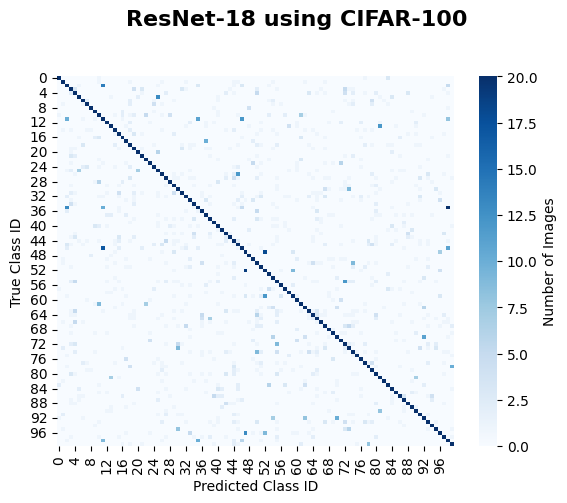

In [38]:
conf_matrix_heatmap(overall_confusion_matrix, model_name,dataset_name)

How we can use confusion matrix?

In [39]:
def get_top_confusions(y_true, y_pred, class_names, top_n=10):
    cm = confusion_matrix(y_true, y_pred)
    np.fill_diagonal(cm, 0) # Zero out correct predictions (diagonal) to find errors
    
    pairs = []
    for i in range(100):
        for j in range(100):
            if cm[i, j] > 0:
                pairs.append((i, j, cm[i, j]))
    
    # Sort in descending order
    pairs.sort(key=lambda x: x[2], reverse=True)
    
    print(f">>> Top {top_n} Confusions <<<")
    for i in range(min(top_n, len(pairs))):
        true_idx, pred_idx, count = pairs[i]
        
        t_name = class_names[true_idx] if class_names else str(true_idx)
        p_name = class_names[pred_idx] if class_names else str(pred_idx)
        
        print(f"True: {class_labels.index(t_name)} - {t_name:<15} Predicted: {class_labels.index(p_name)} - {p_name:<15} Count: {count}")
        
get_top_confusions(y_true,y_pred,class_labels)

>>> Top 10 Confusions <<<
True: 35 - girl            Predicted: 98 - woman           Count: 20
True: 52 - oak_tree        Predicted: 47 - maple_tree      Count: 19
True: 47 - maple_tree      Predicted: 52 - oak_tree        Count: 18
True: 46 - man             Predicted: 11 - boy             Count: 17
True: 2 - baby            Predicted: 11 - boy             Count: 14
True: 5 - bed             Predicted: 25 - couch           Count: 13
True: 35 - girl            Predicted: 2 - baby            Count: 13
True: 96 - willow_tree     Predicted: 47 - maple_tree      Count: 13
True: 11 - boy             Predicted: 46 - man             Count: 12
True: 13 - bus             Predicted: 81 - streetcar       Count: 12


Below we will plot on confusion matrix top 3 wrongly classified classes

Marking: girl (ID 35) -> woman (ID 98)
Marking: oak_tree (ID 52) -> maple_tree (ID 47)
Marking: man (ID 46) -> boy (ID 11)


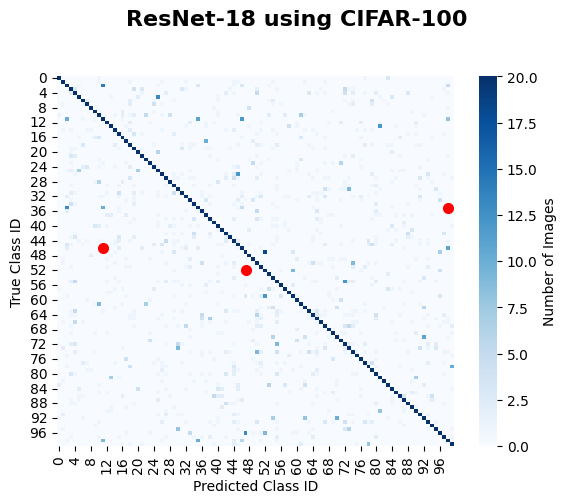

In [43]:
conf_matrix_heatmap(overall_confusion_matrix, model_name,dataset_name, dots_to_plot=[[35,98], [52,47], [46,11]], class_labels=class_labels)

Let's take a look on girl <-> woman.

In [45]:
print_analytics_of_conf_matrix(per_class_confusion_matrices, 'girl')

Confusion matrix for girl
[[9872   28]
 [  54   46]]

When image was actually 'girl', but the model predicted:
 - girl: 46 times
 - woman: 20 times
 - baby: 13 times
 - boy: 10 times
 - man: 5 times


We can also see these cases on actual data.

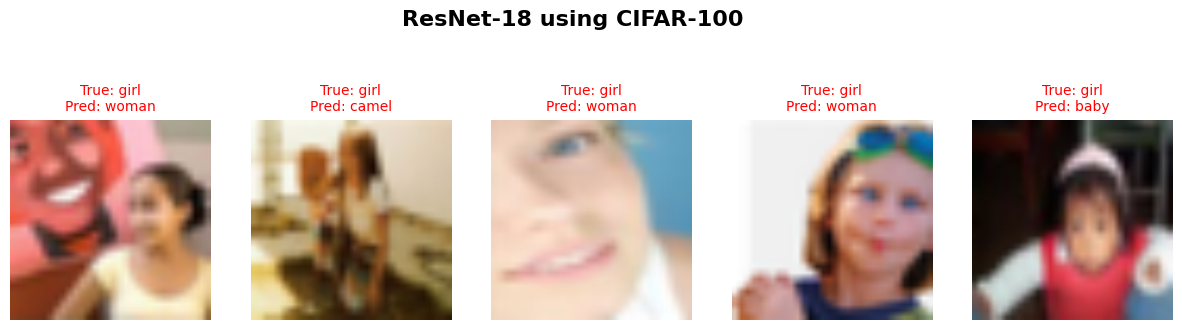

In [46]:
visualize_model_predictions(model,test_loader,class_labels,'girl')

## Efficiency Analytics
Main idea of this section is to analyse disk space required to store model, how much parameters model has, time of forward pass duration (how much time it takes from the moment an input tensor enters the first layer until the probability vector exits the final layer).

In [ ]:
def get_efficiency_metrics(model, loader, device, model_path):
    model.eval()

    #model size
    size_mb = os.path.getsize(model_path) / (1024 * 1024)

    #total numb of parameters
    params = sum(p.numel() for p in model.parameters())
    
    num_samples = 0
    start_time = time.time()
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)            
            num_samples += images.size(0)
            
            if i >= 10: break 
            
    end_time = time.time()
    avg_inference_time = (end_time - start_time) / num_samples

    print(f">>> Global Efficiency & Confidence Metrics")
    print(f"Model Size:       {size_mb:.2f} MB")
    print(f"Total Params:     {params:,}")
    print(f"Inference Time:   {avg_inference_time*1000:.2f} ms per image")
  
    return size_mb, params, avg_inference_time

get_efficiency_metrics(model, test_loader, device, model_path)

>>> Global Efficiency & Confidence Metrics
Model Size:       42.91 MB
Total Params:     11,227,812
Inference Time:   44.13 ms per image


(42.90992259979248, 11227812, 0.044132319363680755)

## Conclusions

### Training Strategy
The comparison clearly identifies **Full Fine-Tuning** as the superior approach for the complex CIFAR-100 dataset. 
* **Head Only (57.36%)**: Failed to capture necessary features, resulting in significant underfitting.
* **Last Block (75.34%)**: Provided a massive boost by adapting high-level features but hit a performance ceiling.
* **Full Tuning (80.78%)**: Achieved the best results. Although the validation loss gap indicates some overfitting, this trade-off was necessary and successful to maximize the model's ability to distinguish between 100 fine-grained classes.

### Model Reliability & Balance
The model demonstrates a strong equilibrium, with **Precision, Recall, and F1-Score all averaging ~80%**.
However, the performance is not uniform. The distribution plots reveal high variance: while the model identifies distinct objects (like 'apple' or 'bus') with near-perfect accuracy, it struggles significantly with a specific "long tail" of difficult classes where performance drops towards 50%.

### Error Analysis
The confusion matrix analysis reveals that the model's mistakes are largely **semantic** rather than random. The top confusions occur between visually and conceptually similar categories (e.g., `Girl` ↔ `Woman`, `Oak Tree` ↔ `Maple Tree`, `Man` ↔ `Boy`).
This indicates that the model successfully learns the **super-classes** (knowing an image is a "Human" or a "Tree") but occasionally fails to distinguish the specific **sub-class** nuances.

### Efficiency
ResNet-18 proves to be a highly efficient backbone for this task. With a relatively compact model size (~43 MB) and fast inference speeds, it offers an excellent trade-off between computational cost and accuracy. It is well-suited for deployment in environments where resources are moderate but high accuracy is required.